# Encoder-decoder network implementation
---
The third notebook in the row. It assumes that we know how to build both Encoder and Decoder networks.

The general idea is to create and combine two networks - endoder and decoder.
After using N encoder bloks we take key `K` and `V` from the final block and inject them to every
decoder block. In the decoder block query `Q` comes from the decoder, whereas `K` and `V` come from the encoder. We may interpret is as: how much the word `Q` (from translation) should pay attention to each words (`K`) in the sentence.


 <img src="./images/encoder-decoder.png" alt="Attention and Multi-head Attention" width="545" />
 
*Image from [Attention is All you need](https://arxiv.org/abs/1706.03762) paper*

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataset

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime


### Multi-Head Attention block

`MultiHeadAttention` block should be more general this time. Specifically, `K` and `V` may come from another source than `Q`, and, as a result, have diferent shapes (diferent number of words). This is very natural, an English sentence and its Polish translation do not have to have the same number of words.
We denote the length of the inputs as $T_{input}$, and the length of the outputs as  $T_{output}$. As a consequence, `K` and `V` have shapes  $T_{input} \times d_k$ and `Q` has shape $T_{output} \times d_k$.

In fact, we are using $n_{heads}$ heads and $N$ batches, so the "full" shapes are:
- for `K` and `V`: $N \times n_{heads} \times T_{input} \times d_k$
- for `Q`: $N \times n_{heads} \times T_{output} \times d_k$

The shapes are being changed in the code to keep the tensors squeezed or to make the tensor operations possible. Pay attention to the notes.

Additionally, in the encoder-decoder structure, we will use two types of Multi-head attention blocks - with and without causal mask. The `causal` parameter takes care about it. 




In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_k, d_model, n_heads, max_len, causal=False):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_k
        self.n_heads = n_heads
        
        self.query = nn.Linear(d_model, d_k * n_heads)
        self.key = nn.Linear(d_model, d_k * n_heads)
        self.value = nn.Linear(d_model, d_k * n_heads)
        
        self.out = nn.Linear(d_k * n_heads, d_model)
        
        # Causal mask
        self.causal = causal
        if causal: 
            cm = torch.tril(torch.ones(max_len, max_len))
            self.register_buffer(
                'causal_mask',
                cm.view(1, 1, max_len, max_len)
            )
        
        
    def forward(self, q, k, v, pad_mask=None):
        
        # Attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) V
        
        q = self.query(q) # N x T_output x (h*d_k) 
        k = self.key(k)   # N x T_input x (h*d_k)
        v = self.value(v) # N x T_input x (h*d_v) # d_v == d_k
        
        N = q.shape[0] # batch size
        T_output = q.shape[1] # Sequence length q
        T_input = k.shape[1] # Sequence length for k amd v
        
        # Changing shapes (reuqired for matrix multiplication)
        # view: (N, T, h*d_k) -> (N, T, h, d_k)
        # transpose: (N, T, h, d_k) -> (N, h, T, d_k)
        q = q.view(N, T_output, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(N, T_input, self.n_heads, self.d_k).transpose(1, 2)
        
        # (N, h, T_output, d_k) x (N, h, d_k, T_input) -> (N, h, T_output, T_input)
        atention_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
        
        if pad_mask is not None:
            # Mask has (N, T_input) shape, so we need to add two (inner) dimensions
            # We also change zeros with -inf, so that softmax will ignore these values
            atention_scores = atention_scores.masked_fill(
                 pad_mask[:, None, None, :] == 0, float('-inf')
                 )
            
        # We also may need to add cusal mask, so that we don't look into the future
        # Max_len is the length of the longest sequence possible, but in fact,
        # we need the longest sequence in the batch. Thus we crop causal mask to :T size      
        # Moreover, after getting rid of first two dimensions (batch size and number of heads)
        # Our mask number of rows corresponds to the Q sequence length, and number of columns
        # corresponds to the K sequence length. Thus we need to crop the mask to the size of
        # Q sequence length and K sequence length.
        # Note 2: In the decoder part Q comes from the decoder, whereas K and V come from 
        # the encoder. We may interpret is as: how much the word Q (from translation)
        # should pay attention to each words K in the sentence.  
        if self.causal:      
            atention_scores = atention_scores.masked_fill(
                    self.causal_mask[:, :, :T_output, :T_input] == 0, float('-inf')
                    )
        
        attention_weights = F.softmax(atention_scores, dim=-1)
        
        # (N, h, T_output, T_input) x (N, h, T_input, d_k) -> (N, h, T_output, d_k)
        A = attention_weights @ v
        
        # Reshape (N, h, T_output, d_k) -> (N, T_output, h, d_k) -> (N, T_output, h*d_k)
        A = A.transpose(1, 2)
        A = A.contiguous().view(N, T_output, self.n_heads * self.d_k)
        
        return self.out(A)
        
        
                

### Encoder block

In [3]:
class EncoderBlock(nn.Module):
    def __init__(self, d_k, d_model, n_heads, max_len, dropout=0.1):
        super().__init__()
                
        self.attention = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=False)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
        self.ff = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )
        
    def forward(self, x, pad_mask=None):
        x = self.norm1(x + self.attention(x, x, x, pad_mask))
        x = self.norm2(x + self.ff(x))
        x = self.dropout(x)
        return x

### Decoder block

In [4]:
class DecoderBlock(nn.Module):
    def __init__(self, d_k, d_model, n_heads, max_len, dropout=0.1):
        super().__init__()
                
        self.attention_1 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=True)
        self.norm1 = nn.LayerNorm(d_model)

        self.attention_2 = MultiHeadAttention(d_k, d_model, n_heads, max_len, causal=False)
        self.norm2 = nn.LayerNorm(d_model)

        self.ff = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )

        self.norm3 = nn.LayerNorm(d_model)


        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, enc_output, dec_input, enc_mask=None, dec_mask=None):
        x = self.norm1(dec_input + self.attention_1(dec_input, dec_input, dec_input, dec_mask))
        
        x = self.norm2(x + self.attention_2(x, enc_output, enc_output, enc_mask))
        
        x = self.norm3(x + self.ff(x))
        return self.dropout(x)


In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2048, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
        # [ [0], [1], [2], ..., [max_len-1] ]
        # 2d array of size max_len x 1
        position = torch.arange(max_len).unsqueeze(1)
        
        #[0, 2, 4, ...]
        exp_term = torch.arange(0, d_model, 2) 
        
        
        div_term = torch.exp(exp_term * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x.shape: N x T x D
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)
        
        

### Encoder

In [6]:
class Encoder(nn.Module):
    def __init__(
        self, 
        vocab_size : int,
        max_len : int,
        d_k : int,
        d_model : int,
        n_heads : int,
        n_layers : int,
        dropout : float = 0.1,
    ):
    
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout=dropout)
        transformer_blocks = [
            EncoderBlock(d_k, d_model, n_heads, max_len, dropout=dropout)
            for _ in range(n_layers)
        ]
        
        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.norm = nn.LayerNorm(d_model)
        
    def forward(self, x, pad_mask = None):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for block in self.transformer_blocks:
            x = block(x, pad_mask)
        
        x = self.norm(x)
        return x
        
        

### Decoder

In [7]:
class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size,
        max_len,
        d_k,
        d_model,
        n_heads,
        n_layers,
        dropout,
    ):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len, dropout=dropout)
        transformer_blocks = [
            DecoderBlock(d_k, d_model, n_heads, max_len, dropout=dropout)
            for _ in range(n_layers)
        ]

        self.transformer_blocks = nn.Sequential(*transformer_blocks)
        self.norm = nn.LayerNorm(d_model)
        self.out = nn.Linear(d_model, vocab_size)
        
    def forward(self, enc_output, dec_input, enc_mask = None, dec_mask = None):
        x = self.embedding(dec_input)
        x = self.pos_encoding(x)
        
        for block in self.transformer_blocks:
            x = block(enc_output, x, enc_mask, dec_mask)
                
        x = self.norm(x)
        return self.out(x)

In [8]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder


    def forward(self, enc_input, dec_input, enc_mask, dec_mask):
        enc_output = self.encode(enc_input, enc_mask)
        dec_output = self.decode(enc_output, dec_input, enc_mask, dec_mask)    
        return dec_output
    
    def encode(self, enc_input, enc_mask):
        return self.encoder(enc_input, enc_mask)
    
    def decode(self, enc_output, dec_input, enc_mask, dec_mask):
        return self.decoder(enc_output, dec_input, enc_mask, dec_mask)

### Quick test

In [9]:
encoder = Encoder(
    vocab_size=20_000,
    max_len = 1024,
    d_k = 16,
    d_model = 64,
    n_heads = 4,
    n_layers = 2,
    dropout = 0.1,
)

decoder = Decoder(
    vocab_size=10_000,
    max_len = 1024,
    d_k = 16,
    d_model = 64,
    n_heads = 4,
    n_layers = 2,
    dropout = 0.1,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transformer = Transformer(encoder, decoder)
transformer = transformer.to(device)


In [10]:
batch_size = 8
nr_words_enc = 512
nr_words_dec = 256

x = np.random.randint(0, 20_000, size=(batch_size, nr_words_enc))
enc_input = torch.tensor(x).to(device)

enc_mask = np.ones((batch_size, nr_words_enc))
enc_mask[:, int(nr_words_enc/2):] = 0 # Let's cut off the second part of the sequence
enc_mask = torch.tensor(enc_mask).to(device)

x = np.random.randint(0, 10_000, size=(batch_size, nr_words_dec))
dec_input = torch.tensor(x).to(device)
dec_mask = np.ones((batch_size, nr_words_dec))
dec_mask[:, int(nr_words_dec/2):] = 0 # Let's cut off the second part of the sequence
dec_mask = torch.tensor(dec_mask).to(device)



y = transformer(enc_input, dec_input, enc_mask, dec_mask)
print (y.shape)
print (y.argmax(dim=-1).shape)


torch.Size([8, 256, 10000])
torch.Size([8, 256])


### Prepare train dataset

In [11]:
#!wget -nc https://lazyprogrammer.me/course_files/nlp3/spa.txt
#!cat spa.txt | wc -l
#!head spa.txt

In [12]:
import pandas as pd
df = pd.read_csv('./spa.txt', sep='\t', header=None, names=['en', 'es'])
df.to_csv('./spa.csv', index=False)
df.head()

,en,es
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Hi.,Hola.
4,Run!,¡Corre!


en max length:  47
es max length:  53


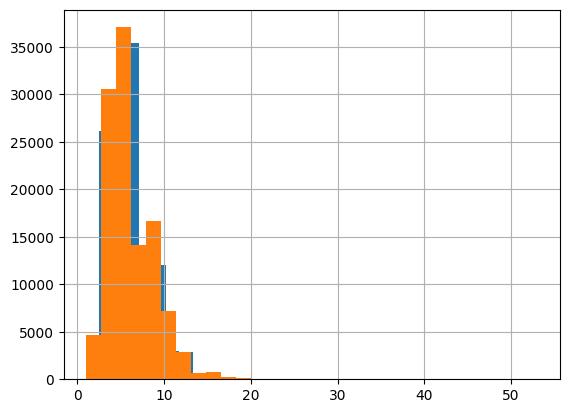

In [13]:
en_length = df.en.apply(lambda x: len(x.split()))
en_length.hist(bins=30)
es_length = df.es.apply(lambda x: len(x.split()))
es_length.hist(bins=30)

print('en max length: ', en_length.max())
print('es max length: ', es_length.max())

In [14]:
from datasets import load_dataset
raw_dataset = load_dataset("csv", data_files='spa.csv')
raw_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['en', 'es'],
        num_rows: 115245
    })
})

In [15]:
split = raw_dataset['train'].train_test_split(test_size=0.1, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['en', 'es'],
        num_rows: 103720
    })
    test: Dataset({
        features: ['en', 'es'],
        num_rows: 11525
    })
})

In [16]:
from transformers import AutoTokenizer

# We can use two different tokenizers for English and Spanish, or 
# we can use the same tokenizer for both languages. (We'll use the same tokenizer.)
model_checkpoint = "Helsinki-NLP/opus-mt-en-es"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [17]:
en_sentence = split['train'][0]['en']
es_sentence = split['train'][0]['es']
inputs = tokenizer(en_sentence)
targets = tokenizer(text_target=es_sentence)
print ('Inputs:', en_sentence, inputs)
print ('Targets:', es_sentence, targets)

tokenizer.convert_ids_to_tokens(targets['input_ids'])



Inputs: Your hair is pretty. {'input_ids': [1072, 4534, 31, 4438, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}
Targets: Tu pelo es bonito. {'input_ids': [1710, 6682, 43, 11008, 3, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


['▁Tu', '▁pelo', '▁es', '▁bonito', '.', '</s>']

In [18]:
max_input_length = 128
max_target_length = 128

def preprocess_function(batch):
    model_inputs = tokenizer(batch["en"], truncation=True, max_length=max_input_length)
    labels = tokenizer(batch["es"], truncation=True, max_length=max_target_length)
    
    model_inputs['labels'] = labels['input_ids']
    # The masks for labels will be created in the training step
    # This is because in fact we do not want to mask the labels, but the
    # decoder inputs. And the decoder inputs are labels shifted to the right    
    return model_inputs

tokenized_datasets = split.map(
    preprocess_function, 
    batched=True,
    remove_columns=split['train'].column_names,
)

tokenized_datasets

Map:   0%|          | 0/103720 [00:00<?, ? examples/s]

Map:   0%|          | 0/11525 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 103720
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 11525
    })
})

In [19]:
from transformers import DataCollatorForSeq2Seq
data_collator = DataCollatorForSeq2Seq(tokenizer)
batch = data_collator([tokenized_datasets["train"][i] for i in range(5)])
for key in batch.keys():
    print (f"{key}: {batch[key].shape}")
    
print (batch['input_ids'])
print (batch['attention_mask'])
print (batch['labels'])

input_ids: torch.Size([5, 13])
attention_mask: torch.Size([5, 13])
labels: torch.Size([5, 16])
tensor([[ 1072,  4534,    31,  4438,     3,     0, 65000, 65000, 65000, 65000,
         65000, 65000, 65000],
        [   33, 10626,   381,  2892,    13,   381,  5661,     3,     0, 65000,
         65000, 65000, 65000],
        [   33,    20,    96,   172,    40,    13,  1504,   125,  4315,     3,
             0, 65000, 65000],
        [   33,     9,    83,   785,  3676,    21,     0, 65000, 65000, 65000,
         65000, 65000, 65000],
        [   70,  1157,  2073,   116,     2,    10,    33,    20,   210,    44,
          2778,     3,     0]])
tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
tensor([[ 1710,   591, 10499,    43, 26428,  5042,     3,     0,  -100,  -100,
          -100,  -100,  -100,

In [20]:
print ('Special ids:', tokenizer.all_special_ids)
print ('Special tokens:', tokenizer.all_special_tokens)
print ('Vocab size:', tokenizer.vocab_size)
tokenizer.decode([tokenizer.pad_token_id, tokenizer.eos_token_id, tokenizer.unk_token_id])

Special ids: [0, 1, 65000]
Special tokens: ['</s>', '<unk>', '<pad>']
Vocab size: 65001


'<pad> </s> <unk>'

We do not have a start token, but we are going to need it. Thus, let's add our own token

In [21]:
tokenizer.add_special_tokens({'cls_token': '<s>'})
print ('cls_token:', tokenizer.cls_token)
print ('cls_token_id:', tokenizer.cls_token_id)
print ('Vocab size:', tokenizer.vocab_size) # not updated, probably a bug
print (tokenizer('<s>'))

cls_token: <s>
cls_token_id: 65001
Vocab size: 65001
{'input_ids': [65001, 0], 'attention_mask': [1, 1]}


In [22]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    batch_size=32,
    collate_fn=data_collator
)
valid_loader = DataLoader(
    tokenized_datasets["test"],
    batch_size=32,
    collate_fn=data_collator
)

### Model training

In [23]:
encoder = Encoder(
    vocab_size = tokenizer.vocab_size + 1,
    max_len = 256,
    d_k = 16,
    d_model = 64,
    n_heads = 4,
    n_layers = 3,
    dropout = 0.1
)

decoder = Decoder(
    vocab_size = tokenizer.vocab_size + 1,
    max_len = 512,
    d_k = 16,
    d_model = 64,
    n_heads = 4,
    n_layers = 3,
    dropout = 0.1
)
transformer = Transformer(encoder, decoder)  

transformer = Transformer(encoder, decoder)
transformer = transformer.to(device)


In [24]:
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)

In [25]:
def translate(prompt, model, max_steps = 32, tokenizer = tokenizer, device = device):
    
    # get encoder output first
    enc_input = tokenizer(prompt, return_tensors='pt').to(device)
    enc_output = model.encode(enc_input['input_ids'], enc_input['attention_mask'])

    # setup initial decoder input
    dec_input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)
    dec_attn_mask = torch.ones_like(dec_input_ids, device=device)

    # now do the decoder loop
    for _ in range(max_steps):
        dec_output = model.decode(
            enc_output,
            dec_input_ids,
            enc_input['attention_mask'],
            dec_attn_mask,
        )

        # choose the best value of the last token
        prediction_id = torch.argmax(dec_output[:, -1, :], axis=-1)

        # append to decoder input
        dec_input_ids = torch.hstack((dec_input_ids, prediction_id.view(1, 1)))

        # recreate mask
        dec_attn_mask = torch.ones_like(dec_input_ids)

        # exit when reach </s>
        if prediction_id == tokenizer.eos_token_id:
            break

    translation = tokenizer.decode(dec_input_ids[0, 1:])
    return translation

translate('I like to eat apples.', transformer)

'Νίκος▁elaborating tomografía▁awardfici tapa albergueĐứ▁InitiationSpyالعربية简体中文Tunisia Mujeres Rhode echado Resolv▁WMD cromática artísticas Arre▁vary Lina\uf06b Sentí▁Sanitation▁OEM, parezca▁sounds卧虎山▁Recreation sondeo'

In [26]:
def train(model, criterion, optimizer, train_loader, epochs, valid_loader = None, print_every = 1):
    def preprocess_batch(batch):
        """
            This function preprocess the batch so that it can be fed to the model.
            It is quite complex and used in both training and validation, so we
            define it here.        
            Note - another option is to create both dec_inputs and dec_masks 
            in the dataloader, and not to do it here. This is the traedeof
            between speed and memory.
        """
        enc_input = batch['input_ids']
        enc_mask = batch['attention_mask']
        targets = batch['labels']
         
        dec_input = targets.clone().detach()

        dec_input = torch.roll(dec_input, shifts=1, dims = 1)
        dec_input[:, 0] = tokenizer.cls_token_id
        
        # We cannot pass -100 in the model, as this cannot go to the 
        # embedding matrix (it's out of bounds - embeddings are 0-vocab_size). 
        # We replace it by pad_token_id
        dec_input = dec_input.masked_fill(dec_input == -100, tokenizer.pad_token_id)
        
        # Creating decoder mask
        dec_mask = torch.ones_like(dec_input)
        dec_mask = dec_mask.masked_fill(dec_input == tokenizer.pad_token_id, 0)
        # Note - another option is to create both dec_inputs and dec_masks 
        # in the dataloader, and not to do it here. This is the traedeof
        # between speed and memory. 
        return enc_input, enc_mask, dec_input, dec_mask, targets
    
    train_losses = np.zeros(epochs)
    valid_losses = np.zeros(epochs)
    
    for epoch in range (epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []
        print ('Training...    \r', end = '')
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()
            
            enc_input, enc_mask, dec_input, dec_mask, targets = preprocess_batch(batch)
            
            
            outputs = model(enc_input, dec_input, enc_mask, dec_mask)
            
            # This part is tricky. Our output shape is N x T x V, 
            # where N is batch size, T is sequence length, and V is vocab size,
            # and our targets shape is N x T.
            # CrossEntropyLoss expects scores in the form 
            # N x V x T, so we need to transpose     
            loss = criterion(outputs.transpose(2, 1), targets)
            
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)


        if valid_loader is not None:
            print ('Validating...    \r', end = '')
            model.eval()
            valid_loss = []
            for batch in valid_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                enc_input = batch['input_ids']
                enc_mask = batch['attention_mask']
                targets = batch['labels']
                
                
                enc_input, enc_mask, dec_input, dec_mask, targets = preprocess_batch(batch)
                
                outputs = model(enc_input, dec_input, enc_mask, dec_mask)
                loss = criterion(outputs.transpose(2, 1), targets)
                valid_loss.append(loss.item())
            
            valid_loss = np.mean(valid_loss)
        else:
            valid_loss = np.nan
        
        train_losses[epoch] = train_loss
        valid_losses[epoch] = valid_loss

        translation = translate(
            prompt = "I am ready", 
            model = model, 
            max_steps = 10,
            tokenizer = tokenizer, 
            device = device
            )

        
        if epoch%print_every == 0:
            t1 = datetime.now() - t0
            minutes, seconds = divmod(t1.total_seconds(), 60)
            formatted_time = "{:02}:{:02}".format(int(minutes), int(seconds))
            
            
            print (f'Epoch: {epoch}: Train loss: {train_loss:.2f}, Valid loss: {valid_loss:.2f}, Duration: {formatted_time}min, Text: {translation}')
           
           
    return train_losses, valid_losses



In [27]:
train_losses, valid_losses = train(
    model=transformer, 
    criterion=criterion, 
    optimizer=optimizer,   
    train_loader=train_loader, 
    valid_loader=valid_loader, 
    epochs=100
)

Epoch: 0: Train loss: 3.61, Valid loss: 2.56, Duration: 03:15min, Text: Estoy cansado.</s>
Epoch: 1: Train loss: 2.63, Valid loss: 2.13, Duration: 03:13min, Text: Estoy▁listo.</s>
Epoch: 2: Train loss: 2.33, Valid loss: 1.90, Duration: 03:16min, Text: Estoy▁listo.</s>
Epoch: 3: Train loss: 2.15, Valid loss: 1.77, Duration: 03:16min, Text: Estoy▁listo.</s>
Epoch: 4: Train loss: 2.03, Valid loss: 1.67, Duration: 03:14min, Text: Estoy▁listo.</s>
Epoch: 5: Train loss: 1.94, Valid loss: 1.62, Duration: 03:14min, Text: Estoy▁listo.</s>
Epoch: 6: Train loss: 1.87, Valid loss: 1.55, Duration: 03:17min, Text: Estoy▁listo▁listo.</s>
Epoch: 7: Train loss: 1.81, Valid loss: 1.51, Duration: 03:16min, Text: Estoy▁listo▁listo.</s>
Epoch: 8: Train loss: 1.75, Valid loss: 1.46, Duration: 03:14min, Text: Estoy▁listo▁listo.</s>
Epoch: 9: Train loss: 1.71, Valid loss: 1.44, Duration: 03:15min, Text: Estoy▁listo.</s>
Epoch: 10: Train loss: 1.67, Valid loss: 1.41, Duration: 03:14min, Text: Estoy▁listo.</s>


In [30]:
translate('I love you', transformer)

'Te amo.</s>'